# CODE: A graph-based superpixel segmentation method for measuring pressure ulcers

This code is used to generate overlapping and statistics using Python. The main program in Java provide the same way to achieve the objectives. This code extendend previous analisys in Silva e Machado (2021), improve the analysis for DISF, ERS, SNIC, and possibility extend future funcionalities and approaches for this research using Python.

# Mount the drive to access files

In [ ]:
# Montar o drive do google
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load libraries

In [ ]:
# Importar bibliotecas
import cv2
import os
import pandas as pd
import numpy as np
import imutils
import time
import csv
import matplotlib.pyplot as plt
from collections import Counter
from scipy.sparse import csr_matrix
from google.colab.patches import cv2_imshow

# Main functions

In [ ]:
# REMOVE GLARE
def remove_glare(img):
  # convert to gray
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  blurred = cv2.GaussianBlur(gray, (3,3), 0)
  thresh = cv2.threshold(blurred, 225, 255, cv2.THRESH_BINARY)[1]
  
  # threshold grayscale image to extract glare
  mask = cv2.threshold(thresh, 200, 255, cv2.THRESH_BINARY)[1]
  
  # Optionally add some morphology close and open, if desired
  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))
  mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=1)
  #kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
  #mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)

  # use mask with input to do inpainting
  inpainting = cv2.inpaint(img, mask, 3, cv2.INPAINT_TELEA) 
  # media filter for noise reduction
  result = cv2.GaussianBlur(inpainting, (3,3), 0)
  # write result to disk
  #cv2.imwrite("image_mask.png", mask)
  #cv2.imwrite("image_inpaint.png", result)
  
  # display it
  #cv2_imshow(img)
  #cv2_imshow(gray)
  #cv2_imshow(blurred)
  #cv2_imshow(thresh)
  #cv2_imshow(mask)
  #cv2_imshow(result)

  return result, thresh

# CONVERT IMG TO PGM
def convert_pgm(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img[img < 127] = 0
  img[img != 0] = 255
  #cv2_imshow(img)
  return img

# https://github.com/andrewseaman35/aseaman/blob/7361d3c0611dd8932982d84ad4bde927f89acee7/exploration/draw_jasper/run_comparison.py
def binary_gt(path_dir_name):
  for i in path_dir_name:
    if i == '.ipynb_checkpoints':
      continue

    # LOAD IMAGE
    img_name = path+'/'+str(i)+'/'+str(i)+'_02_LABELED_RESAMPLE.jpg'
    img = cv2.imread(img_name)
    
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    gray[gray < 11] = 0
    gray[gray >= 11] = 255

    # FIND OUTER CONTOUR AND FILL WITH WHITE
    cnts = cv2.findContours(gray, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    
    blackMask = np.zeros([240, 300, 1], dtype=np.uint8)

    #polyMask = cv2.polylines(blackMask, cnts, isClosed = True, color=(0,0,0) , thickness = 3)
    result = cv2.fillPoly(blackMask, cnts, [255])
    #kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3))
    #morph1 = cv2.morphologyEx(result, cv2.MORPH_ERODE, kernel)
    #morph2 = cv2.morphologyEx(result, cv2.MORPH_OPEN, kernel)
    
    print("Resultado")
    cv2_imshow(result)

    # Save Binary Ground Truth
    #img_name = path+'/'+str(i)+'/'+str(i)+'_00_GROUND_TRUTH_BINARY.jpg'
    #cv2.imwrite(img_name, morph2)
    #plt.imsave(img_name, thresh, cmap = plt.cm.binary_r) 

# COMPUTE SEEDS
def seeds_computation(ulcerRegion, nonUlcerRegion, nblack_seeds, nwhite_seeds): 
  # Get dimensions of image
  dim = nonUlcerRegion.shape
  # Height, width, number of channels in image
  height = nonUlcerRegion.shape[0]
  width = nonUlcerRegion.shape[1]
  #channels = nonUlcerRegion.shape[2]
  # Print dimensions
  print("As dimensões da imagem são", dim)
  npixels = height*width
  print("O número total de pixels é", npixels)
  
  # Retrieval white pixels coodinates from nonUlcerRegion binary image 
  #list(white = np.where(nonUlcerRegion == [255]))
  first_row = nonUlcerRegion[0, :]
  last_row = nonUlcerRegion[239, :]
  first_column = nonUlcerRegion[:, 0]
  last_column = nonUlcerRegion[:, 299]

  white = np.zeros(nonUlcerRegion.shape)
  #white = np.zeros(dim, dtype=int)
  white[0, :] = first_row
  white[239, :] = last_row
  white[:, 0] = first_column
  white[:, 299] = last_column

  # Generate tuple of white pixels coordinates
  white = np.where(white == [255])
  print("O número total de pixels branco é", len(white))
    
  #imgplot = plt.imshow(white)
  #imgplot.set_cmap('binary_r')

  # Retrieval black pixels coodinates from ulcerRegion binary image
  # generate tuple of black pixels coordinates
  black = np.where(ulcerRegion == [0])
  print("O número total de pixels preto é", len(black))

  # Zip (iterator) and convert to list for white pixels matrix (background)
  listzip1 = list(zip(white[0], white[1]))
  coord_bg = np.asarray(listzip1)
  print("O número total de seeds/coordenadas branco é", len(coord_bg))


  # Zip (iterator) and convert to list for black pixels matrix (foreground)
  listzip2 = list(zip(black[0], black[1]))
  coord_fg = np.asarray(listzip2)
  print("Quantidade total de seeds/coordenadas pretos é", len(coord_fg))

  # Amount of all seeds or coords number
  nseeds = int(len(coord_bg)+len(coord_fg))
  print("Quantidade total de seeds/coordenadas é", nseeds)

  # Proportional seeds for black and white regions
  #black_prop = len(coord_bg)/nseeds
  #nblack_seeds = int(black_prop * nseeds)
  #print("A proporção de sementes em regiões de úlcera é", round(float(black_prop)*100, 0))
  #print("A quantidade de seeds preto é", nblack_seeds)

  #white_prop = len(coord_fg)/nseeds
  #nwhite_seeds = int(white_prop * nseeds)
  #print("A proporção de sementes em regiões de não úlcera é", round(float(white_prop)*100, 0))
  #print("A quantidade de seeds branco é", nwhite_seeds)

  # Setup amount of seeds for black regions
  # nblack_seeds = 2800
  if nblack_seeds > len(coord_fg):
    print("Quantidade de seeds pretos maior que o total.")
    print("Quantidade de seeds pretos foi ajustado para o maior valor possível:" , len(coord_fg))
    nblack_seeds = len(coord_fg)

  print("Nova quantidade de seeds preto é", nblack_seeds)
  
  # Setup amount of seeds for white regions
  # nwhite_seeds = 2000
  if nwhite_seeds > len(coord_bg):
    print("Quantidade de seeds brancos maior que o total.")
    print("Quantidade seeds brancos foi ajustado para o maior valor possível:" , len(coord_bg))
    nwhite_seeds = len(coord_bg)
  
  print("Nova quantidade de seeds branco é", nwhite_seeds)

  # Setup the amount of rows from DataFrame (is the same of amount of seeds + header row)
  nrows = nblack_seeds+nwhite_seeds+1
  print("Nova quantidade de seeds/coordenadas é", nrows-1)

  # CREATE SEEDS DATAFRAME WITH LABELS AND COORDINATES
  #header = [nrows-1, width, height]
  # Setup labels: 0 is background / 1 is ulcer / 2 isn't ulcer
  df_header = pd.DataFrame({'x': [nrows], 'y': width, 'conn': height, 'label':''})
  df_white = pd.DataFrame({'x': coord_bg[:, 0], 'y': coord_bg[:, 1],'conn': 1,'label': 2})
  df_black = pd.DataFrame({'x': coord_fg[:, 0], 'y': coord_fg[:, 1],'conn': 1,'label': 1})

  # Select n rows randomly from DataFrame
  rdf_white = df_white.sample(n = nwhite_seeds, replace = True)
  rdf_black = df_black.sample(n = nblack_seeds, replace = True)

  # Concatenate DataFrame without header
  df_data = rdf_white.append(rdf_black)
  #print(df_data)

  # Create seeds file with labels in your specifics coordinates
  seeds = np.zeros(dim, dtype=int)
  seeds[df_data.iloc[:]['x'],df_data.iloc[:]['y']] = df_data.iloc[:]['label'] 

  # Save seeds np array as .txt
  np.savetxt(path+'/'+str(i)+'/'+'seeds.txt', seeds, fmt = '%d')
  print(">>> Um arquivo seeds.txt foi gravado com sucesso!")

  # Save seeds as binary .jpg image
  img_name = path+'/'+str(i)+'/'+str(i)+'_15_SEEDS_DISTRIBUITION.jpg'
  plt.imsave(img_name, seeds, cmap = plt.cm.binary)

  return seeds

# CREATE GT BINARY IMAGE
def binary_gt1(path_dir_name):
  for i in path_dir_name:
    if i == '.ipynb_checkpoints':
      continue
    print("Processando a imagem", i)
    # Load in image, convert to grayscale, and threshold
    img_name = path+'/'+str(i)+'/'+str(i)+'_02_LABELED_RESAMPLE.jpg'
    image = cv2.imread(img_name)
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

    # Close contour
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7,7))
    close = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=1)

    # Find outer contour and fill with white
    cnts = cv2.findContours(close, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    cv2.fillPoly(close, cnts, [255,255,255])
    print("close")
    cv2_imshow(close)

def binary_gt2(path_dir_name):
  for i in path_dir_name:
    if i == '.ipynb_checkpoints':
      continue
    print("Processando a imagem", i)

    # Image reader
    img_name = path+'/'+str(i)+'/'+str(i)+'_02_LABELED_RESAMPLE.jpg'
    img = cv2.imread(img_name) # BRG order, uint8 type
    #cv2_imshow(img)
    # Transform ground truth in binary image
    # convert the image to grayscale format
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Blur image
    # blur = cv2.medianBlur(img_gray,3)
    #blur = cv2.GaussianBlur(img_gray,(7,7),0)

    blur, thresh = remove_glare(img)
    # img_gray = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)
    # visualize the binary image
    #cv2_imshow(blur)
    # cv2_imshow(thresh)
    blur_gray = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)
    #cv2_imshow(blur_gray)

    # Threshold
    #thresh = cv2.adaptiveThreshold(blur, 0, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 3, 5)
    ret, thresh = cv2.threshold(blur_gray, 5, 255, 0, cv2.THRESH_BINARY)
    # ret,thresh = cv2.threshold(blur_gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    #cv2_imshow(thresh)
    
    # Save Binary Ground Truth
    img_name = path+'/'+str(i)+'/'+str(i)+'_00_GROUND_TRUTH_BINARY.jpg'
    #cv2.imwrite(img_name2, thresh)
    plt.imsave(img_name, thresh, cmap = plt.cm.binary_r)   

def isBlackPixel(pixel):

  return pixel < 200

def overlapping_stats(method, i, exec_time, gtBinary, methodBinary):
  # DEFINE COLORS FROM EACH PIXEL REGION
  BLACK_PIXEL = 0;
  DARK_GRAY_PIXEL = 110;
  LIGHT_GRAY_PIXEL = 190;
  WHITE_PIXEL = 255;

  truePositives = 0.0
  trueNegatives = 0.0
  falsePositives = 0.0
  falseNegatives = 0.0

  # OVERLAPPING IMAGE
  # create a new image with white pixels
  overlappingImage = np.ones([240, 300, 3], dtype=np.uint8)*255

  # CREATE OVERLAPPING AND STATISTICS FROM IMAGE COORDINATES
  rows,cols = overlappingImage.shape[:2]

  for ii in range(rows):
      for j in range(cols):
                      
          pixelGt = gtBinary[ii,j]
          pixel = methodBinary[ii,j]  
          #pixelOverlapping = overlappingImage[ii,j]

          #if bool(pixelGt<200) and bool(pixel<200):
          if isBlackPixel(pixelGt) & isBlackPixel(pixel):
            overlappingImage[ii,j] = LIGHT_GRAY_PIXEL
            truePositives += 1
          
          #if not bool(pixelGt<200) and not bool(pixel<200):
          if ~ isBlackPixel(pixelGt) & ~ isBlackPixel(pixel):
            overlappingImage[ii,j] = WHITE_PIXEL
            trueNegatives += 1   

          #if not bool(pixelGt<200) and bool(pixel<200):
          if ~ isBlackPixel(pixelGt) & isBlackPixel(pixel):
            overlappingImage[ii,j] = DARK_GRAY_PIXEL
            falsePositives += 1
          
          #if bool(pixelGt<200) and not bool(pixel<200):
          if isBlackPixel(pixelGt) & ~ isBlackPixel(pixel):
            overlappingImage[ii,j] = BLACK_PIXEL
            falseNegatives += 1 

  # BUILD STATISTICS
  build_statistics(method, i, exec_time, overlappingImage, truePositives, trueNegatives, falsePositives, falseNegatives)

# BUILD STATISTICS
def build_statistics(method, i, exec_time, overlappingImage, truePositives, trueNegatives, falsePositives, falseNegatives):  
  # sensitivity or recall 
  sensitivity = truePositives/(truePositives + falseNegatives)
  # specificity
  specificity = trueNegatives/(trueNegatives + falsePositives)
  # precision 
  precision = truePositives/(truePositives + falsePositives)
  # accuracy
  accuracy = (truePositives + trueNegatives)/(truePositives + trueNegatives + falsePositives + falseNegatives)
  #iou
  iou = truePositives/(truePositives + falsePositives + falseNegatives)
  #sepai list
  sepai_list = [sensitivity, specificity, precision, accuracy, iou]
  #min
  min = np.min(sepai_list)
  #max 
  max = np.max(sepai_list)
  # mean sepai
  sepai =  np.mean(sepai_list)
  
  print("método: ", method)
  print("imagem: ", i)
  print("superpixels: ", 200)
  print("tempo de execução do método", exec_time)
  print("truePositives: ", truePositives)
  print("trueNegatives: ", trueNegatives)
  print("falsePositives: ", falsePositives)
  print("falseNegatives: ", falseNegatives)
  print("sensitivity: ", sensitivity)
  print("specificity: ", specificity)
  print("precision: ", precision)
  print("accuracy: ", accuracy)
  print("iou: ", iou)
  print("min: ", min)
  print("max: ", max)
  print("mean_sepai: ", sepai)

  # CREATE DATAFRAME WITH STATISTICS VALUES
  df_header = pd.DataFrame({'IMAGE_NAME': [i], 'SUPERPIXELS': 200, 'EXECUTION_TIME': exec_time, 'TRUE_POSITIVES': truePositives, 'TRUE_NEGATIVES': trueNegatives, 'FALSE_POSITIVES': falsePositives, 'FALSE_NEGATIVES': falseNegatives, 'SENSITIVITY': sensitivity, 'SPECIFICITY': specificity, 'PRECISION': precision, 'ACCURACY': accuracy, 'INTERSECTION_UNION': iou, 'MIN SEPAI': min, 'MAX SEPAI': max, 'MEAN SEPAI':  sepai})

  mean_name = "MEAN: " 
  std_name = "STD: "

  # DECLARE VARIABLES AVERAGE
  mean_exec_time = 0
  mean_true_positives = 0
  mean_true_negatives = 0
  mean_false_positives = 0
  mean_fafse_negatives = 0
  mean_sensitivity = 0
  mean_specificity = 0
  mean_precision = 0
  mean_accuracy = 0
  mean_iou = 0
  mean_min = 0
  mean_max = 0
  mean_sepai = 0

  # DECLARE VARIABLES STD
  std_exec_time = 0
  std_true_positives = 0
  std_true_negatives = 0
  std_false_positives = 0
  std_fafse_negatives = 0
  std_sensitivity = 0
  std_specificity = 0
  std_precision = 0
  std_accuracy = 0
  std_iou = 0
  std_min = 0
  std_max = 0
  std_sepai = 0

  # AVERAGE
  mean_exec_time = np.mean(exec_time)
  mean_true_positives = np.mean(truePositives)
  mean_true_negatives = np.mean(trueNegatives)
  mean_false_positives = np.mean(falsePositives)
  mean_false_negatives = np.mean(falseNegatives)
  mean_sensitivity = np.mean(sensitivity)
  mean_specificity = np.mean(specificity)
  mean_precision = np.mean(precision)
  mean_accuracy = np.mean(accuracy)
  mean_iou = np.mean(iou)
  mean_min = np.mean(min)
  mean_max = np.mean(max)
  mean_sepai = np.mean(sepai)
  
  # STD
  std_exec_time = np.std(exec_time)
  std_true_positives = np.std(truePositives)
  std_true_negatives = np.std(trueNegatives)
  std_false_positives = np.std(falsePositives)
  std_false_negatives = np.std(falseNegatives)
  std_sensitivity = np.std(sensitivity)
  std_specificity = np.std(specificity)
  std_precision = np.std(precision)
  std_accuracy = np.std(accuracy)
  std_iou = np.std(iou)
  std_min = np.std(min)
  std_max = np.std(max)
  std_sepai = np.std(sepai)

  df_mean = pd.DataFrame({'IMAGE_NAME': [mean_name], 'SUPERPIXELS': 200, 'EXECUTION_TIME': mean_exec_time, 'TRUE_POSITIVES': mean_true_positives, 'TRUE_NEGATIVES': mean_true_negatives, 'FALSE_POSITIVES': mean_false_positives, 'FALSE_NEGATIVES': mean_false_negatives, 'SENSITIVITY': mean_sensitivity, 'SPECIFICITY': mean_specificity, 'PRECISION': mean_precision, 'ACCURACY': mean_accuracy, 'INTERSECTION_UNION': mean_iou, 'MIN SEPAI': mean_min, 'MAX SEPAI': mean_max, 'MEAN SEPAI': mean_sepai})
  df_std = pd.DataFrame({'IMAGE_NAME': [std_name], 'SUPERPIXELS': 200, 'EXECUTION_TIME': std_exec_time, 'TRUE_POSITIVES': std_true_positives, 'TRUE_NEGATIVES': std_true_negatives, 'FALSE_POSITIVES': std_false_positives, 'FALSE_NEGATIVES': std_false_negatives, 'SENSITIVITY': std_sensitivity, 'SPECIFICITY': std_specificity, 'PRECISION': std_precision, 'ACCURACY': std_accuracy, 'INTERSECTION_UNION': std_iou, 'MIN SEPAI': std_min, 'MAX SEPAI': std_max, 'MEAN SEPAI': std_sepai})
  #df_line_space = pd.DataFrame({'IMAGE_NAME': '', 'SUPERPIXELS': '', 'EXECUTION_TIME': '', 'TRUE_POSITIVES': '', 'TRUE_NEGATIVES': '', 'FALSE_POSITIVES': '', 'FALSE_NEGATIVES': '', 'SENSITIVITY': '', 'SPECIFICITY': '', 'PRECISION': '', 'ACCURACY': '', 'INTERSECTION_UNION': '' })

  df_stats = []
  #df_stats = df_header.append(df_line_space)
  df_stats = df_header.append(df_mean)
  #df_stats = df_stats.append(df_mean)
  df_stats = df_stats.append(df_std)

  # SAVE ALL STATISTICS IN DATAFRAME
  #df_all_stats = df_all_stats.append(df_header)

  # SAVE STATISTICS FILE AND OVERLAPPING IMAGE FROM SVM AND GRAB             
  if method == 'SVM':
    img_name = path+'/'+str(i)+'/'+str(i)+'_11_SVM_OVERLAPPING.jpg'
    cv2.imwrite(img_name, overlappingImage)
    file_name = path+'/'+str(i)+'/'+'w_image_statistics_svm.csv'
    df_header.to_csv(file_name)

  if method =='GRAB':
    img_name = path+'/'+str(i)+'/'+str(i)+'_12_GRAB_OVERLAPPING.jpg'
    cv2.imwrite(img_name, overlappingImage)
    file_name = path+'/'+str(i)+'/'+'w_image_statistics_grab.csv'
    df_header.to_csv(file_name)


  # SAVE TXT FILE WITH STATISTICS VALUES FOR VISUALIZATION
  if method == 'SVM':
    stats_file = open(path+"/"+str(i)+"/"+"w_image_statistics_visualization.txt", "w")
  else:
    stats_file = open(path+"/"+str(i)+"/"+"w_image_statistics_visualization.txt", "a")

  stats_file.write("******************************************\n")
  stats_file.write("************* Method: "+ method +" ***************\n")
  stats_file.write("******************************************\n")
  stats_file.write(df_stats.to_string(index=False, header = True))
  stats_file.write("\n\n")
  stats_file.close()

  if method == 'SVM':
    file_name = path+'/'+str(i)+'/'+'w_image_statistics_visualization.csv'
    df_header.to_csv(file_name)
  

# WRITE STATISTICS AFTER THE COMPUTATION
def write_statistics():
  # IMPORT MULTIPLES CSV FILES INTO PANDAS AND CONCATENATE INTO ONE DATAFRAME

  dfGrab = []
  dfSvm = []
  dfMean = []
  dfStd = []
  dfStats = []
  df = []

  mean_name = 'MÉDIA: ' 
  std_name = 'STD: '

  methods = ['SVM','GRAB']
  for method in methods:
    for i in path_dir_name:
      if i == '.ipynb_checkpoints' or i == 'w_image_all_statistics_visualization.txt' or i == 'w_image_all_statistics_visualization_rgb.txt' or i == 'w_image_all_statistics_visualization_lab.txt':
        break
      if method == 'SVM':
        filename = path+'/'+str(i)+'/w_image_statistics_svm.csv'
        df = pd.read_csv(filename, index_col=None, header=0)
        df = df.iloc[: , 1:]
        dfSvm.append(df)
        frame = pd.concat(dfSvm, axis=0, ignore_index=True)
        
      if method == 'GRAB':
        filename =  path+'/'+str(i)+'/w_image_statistics_grab.csv'
        df = pd.read_csv(filename, index_col=None, header=0)
        df = df.iloc[: , 1:]
        dfGrab.append(df)
        frame = pd.concat(dfGrab, axis=0, ignore_index=True)

    dfMean = frame.mean(axis = 0)
    dfMean = dfMean.to_frame().T
    
    dfStd = frame.std(axis = 0)
    dfStd = dfStd.to_frame().T
    
    dfStats = dfMean.append(dfStd)

    print("\nMEDIA E DESVIO PADRÃO DO", method)
    print(dfStats.to_string(index=False))

    #print("\nDESVIO PADRÃO DO", method)
    #print(frame.std(axis = 0))

    #frame = pd.concat(dfMean, axis=0, ignore_index=True)
    #frame = pd.concat(frame.std(axis = 0).to_frame() , axis=0, ignore_index=True)

    if method == 'SVM':
      stats_file = open(path+"/"+"w_image_all_statistics_visualization_"+color_space+".txt", "w")
    else:
      stats_file = open(path+"/"+"w_image_all_statistics_visualization_"+color_space+".txt", "a")

    stats_file.write("******************************************\n")
    stats_file.write("************* Method: "+ method +" ***************\n")
    stats_file.write("******************************************\n")
    stats_file.write(frame.to_string(index=False, header = True))
    stats_file.write("\n\n")
    stats_file.write(dfStats.to_string(index=False, header = True))
    stats_file.write("\n\n")

    stats_file.close()



In [ ]:
write_statistics()

#Main Program
In this code, we execute the main program

In [ ]:
# SETUP DIR
seg_name = 'disf5'
color_space = 'rgb'
path = ('/content/drive/MyDrive/Projeto/test/'+color_space+'/'+seg_name)
path_dir_name = os.listdir(path)
print(path_dir_name)

# MAIN PROGRAM
for i in path_dir_name:
  if i == '.ipynb_checkpoints' or i == 'w_image_all_statistics_visualization_rgb.txt' or i == 'w_image_all_statistics_visualization_lab.txt' or i == 'w_image_all_statistics_visualization.txt' :
    continue
  print("****************************************")
  print("Processando a imagem", i)
  print("****************************************")

  # READ IMAGES IN SPECIFIC COLOR SPACE
  rgbImage = cv2.imread(path+'/'+str(i)+'/'+str(i)+'_01_WITHOUT_REFLECTIONS.jpg')
  labImage = cv2.cvtColor(rgbImage, cv2.COLOR_BGR2LAB)
  hsvImage = cv2.cvtColor(rgbImage, cv2.COLOR_BGR2HSV)

  # READ BINARY IMAGES AND CONVERT TO PGM 
  gtBinary = convert_pgm(cv2.imread(path+'/'+str(i)+'/'+str(i)+'_00_GROUND_TRUTH_BINARY.jpg'))
  svmBinary = convert_pgm(cv2.imread(path+'/'+str(i)+'/'+str(i)+'_05_SVM_CLASSIFICATION.jpg'))
  grabBinary = convert_pgm(cv2.imread(path+'/'+str(i)+'/'+str(i)+'_06_GRABCUT_BINARY_SEGMENTATION.jpg'))
  skeletonBinary = convert_pgm(cv2.imread(path+'/'+str(i)+'/'+str(i)+'_10_SEKELETON_WITHOUT_BRANCHS.jpg'))
  
  # COMPUTE SEEDS
  seeds = seeds_computation(skeletonBinary, svmBinary, 5000, 5000)

  # DEFINE EXECT_TIME ALLEATORY FOR TEST
  exec_time = 0

  # CREATE OVERLAPPING STATS
  methods = ['SVM', 'GRAB']
  for method in methods:
    if method == 'SVM':
      overlapping_stats(method, i, exec_time, gtBinary, svmBinary)
      #break
    if method == 'GRAB':
      overlapping_stats(method, i, exec_time, gtBinary, grabBinary)
      #break
    
print("Programa finalizado com sucesso!")

# COMPUTE AND WRITE STATS FOR SEGMENTATION EVALUATION
write_statistics()
print("Estatísticas criadas com sucesso!")


# UTILS: METHODS FOR TEST SOME APPROACHES
## Pré processing tecniques

This part of the code has some methods for test the approach 

Resultado


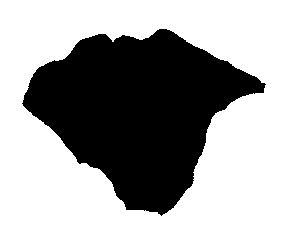

Resultado


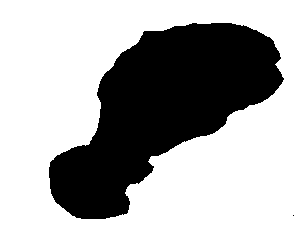

Resultado


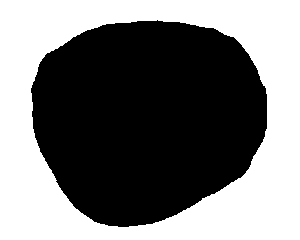

Resultado


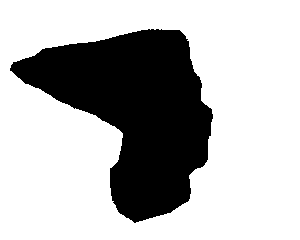

Resultado


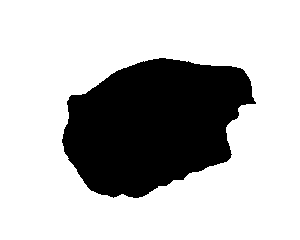

Resultado


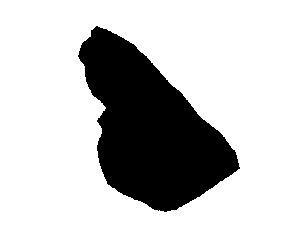

Resultado


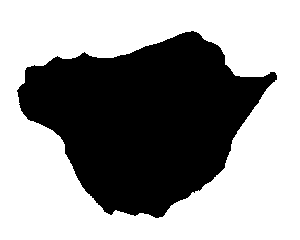

Resultado


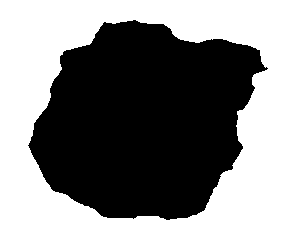

Resultado


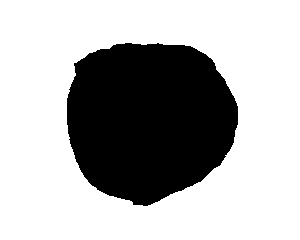

Resultado


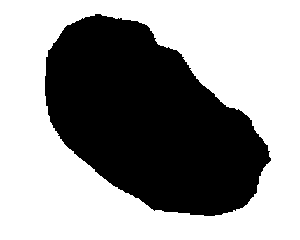

Resultado


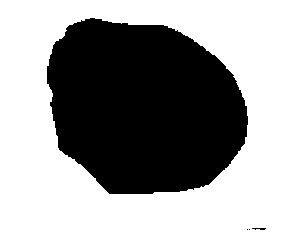

Resultado


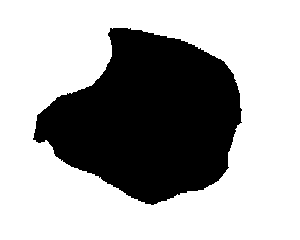

Resultado


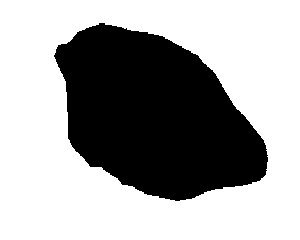

Resultado


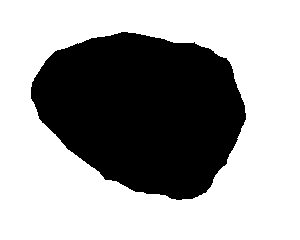

Resultado


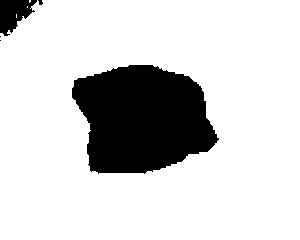

Resultado


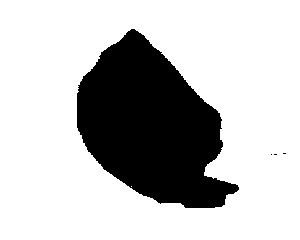

Resultado


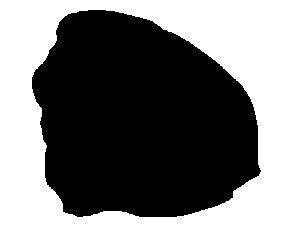

Resultado


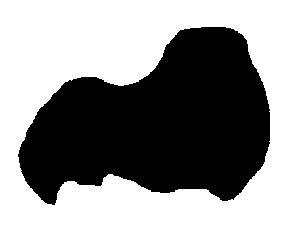

Resultado


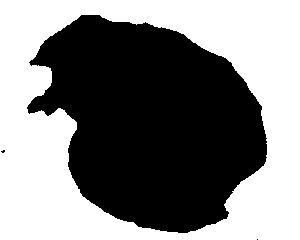

Resultado


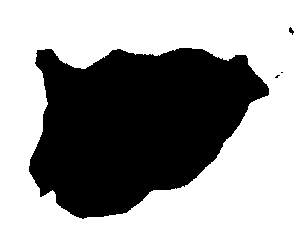

Resultado


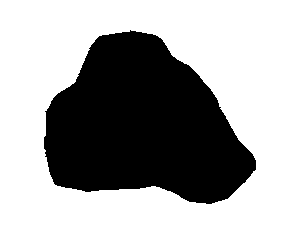

In [ ]:
#img = cv2.imread("/content/drive/MyDrive/Projeto/rgb/disf5/9/9_01_WITHOUT_REFLECTIONS.jpg")
binary_gt(path_dir_name)

In [ ]:
# DILATATION AND EROSION METHODS

from matplotlib import image
import cv2
import numpy as np
 
# Reading the input image
img = cv2.imread("/content/drive/MyDrive/Projeto/rgb/disf5/105/105_10_SKELETON_WITHOUT_BRANCHS.jpg")


# Taking a matrix of size 5 as the kernel
kernel = np.ones((5,5), np.uint8)
 
# The first parameter is the original image,
# kernel is the matrix with which image is
# convolved and third parameter is the number
# of iterations, which will determine how much
# you want to erode/dilate a given image.
img_erosion = cv2.erode(img, kernel, iterations=3)
img_dilation = cv2.dilate(img, kernel, iterations=3)

print("image original")
cv2_imshow(img)
print("image erosion")
cv2_imshow(img_erosion)
print("image dilatation")
cv2_imshow(img_dilation)

# DETECT AND DRAW CONTOURS
def draw_contour(img):
  img_copy = img.copy()
  img_gray = cv2.cvtColor(img_copy, cv2.COLOR_BGR2GRAY)
  contours, hierarchy = cv2.findContours(img_gray, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)
  cv2.drawContours(img_copy, contours, -1, (0,255), 3);
  plt.figure(figsize=[10,10])
  plt.imshow(img_copy[:,:,::-1]); plt.axis("off"); plt.title('Contours Draw');

# DETECT AND DRAW BIGGEST CONTOURS
def draw_largest_contour(img):
  img_copy = img.copy()
  img_gray = cv2.cvtColor(img_copy, cv2.COLOR_BGR2GRAY)
  contours, hierarchy = cv2.findContours(img_gray, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)
  biggest_contour = max(contours, key = cv2.contourArea)
  cv2.drawContours(img_copy, biggest_contour, -1, (0,255), 3);
  plt.figure(figsize=[10,10])
  plt.imshow(img_copy[:,:,::-1]); plt.axis("off"); plt.title('The Biggest Contours Draw');

# SALIENCY DETECTION
def saliency_detection_sr(img):
  img_copy = img.copy()
  # inicialize o detector residual espectral de saliência estática do OpenCV e calcula o mapa de saliência
  saliency = cv2.saliency.StaticSaliencySpectralResidual_create()
  (success, saliencyMap) = saliency.computeSaliency(img_copy)
  saliencyMap = (saliencyMap * 255).astype("uint8")
  cv2_imshow(img_copy)
  cv2_imshow(saliencyMap)

def saliency_detection_sfg(img):
  img_copy = img.copy()
  saliency = cv2.saliency.StaticSaliencyFineGrained_create()
  (success, saliencyMap) = saliency.computeSaliency(img_copy)
  saliencyMap = (saliencyMap * 255).astype("uint8")
  # se quisermos um mapa *binário* que possamos processar para contornos,
  # calcular cascos convexos, extrair caixas delimitadoras, etc., podemos
  # adicionalmente limita o mapa de saliência
  threshMap = cv2.threshold(saliencyMap.astype("uint8"), 0, 255,
	cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
  cv2_imshow(img_copy)
  cv2_imshow(saliencyMap)
  cv2_imshow(threshMap)

def plot_images(img):
  plt.figure(figsize=[10,10])
  plt.imshow(img_copy[:,::-1]); plt.axis("off"); plt.title('Original Image');
  plt.figure(figsize=[10,10])
  plt.imshow(threshMap[:,::-1]); plt.axis("off"); plt.title('Thresh Map Image');
  plt.figure(figsize=[10,10])
  plt.imshow(saliencyMap[:,::-1]); plt.axis("off"); plt.title('Saliency Map Image');

def canny(img):
  # load the image, convert it to grayscale, and blur it slightly
  img = cv2.imread(img)
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  blurred = cv2.GaussianBlur(gray, (5, 5), 0)

  # show the original and blurred images
  cv2.imshow("Original", img)
  cv2.imshow("Blurred", blurred)

  # GRABCUT SEGMENTATION
def grabCutSegmentation(img, mask, ):
  mask, bgdModel, fgdModel = cv.grabCut(img,mask,None,bgdModel,fgdModel,5,cv.GC_INIT_WITH_MASK)
  mask = np.where((mask==2)|(mask==0),0,1).astype('uint8')
  img = img*mask[:,:,np.newaxis]
  plt.imshow(img),plt.colorbar(),plt.show()


In [ ]:
# MORPHOLOGY PROCESSING
# https://stackoverflow.com/questions/67117928/how-to-decide-on-the-kernel-to-use-for-dilations-opencv-python
# read image as grayscale
#img = cv2.imread('blob3.png', cv2.IMREAD_GRAYSCALE)

# threshold to binary
#thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY)[1]

# apply morphology open with square kernel to remove small white spots
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3))
morph1 = cv2.morphologyEx(result, cv2.MORPH_OPEN, kernel)

# apply morphology close with horizontal rectangle kernel to fill horizontal gap
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (20,20))
morph2 = cv2.morphologyEx(morph1, cv2.MORPH_CLOSE, kernel)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
morph3 = cv2.morphologyEx(morph1, cv2.MORPH_OPEN, kernel)

# write results
#cv2.imwrite("blob3_morph1.png", morph1)
#cv2.imwrite("blob3_morph2.png", morph2)

# show results
print("Resultado Original")
cv2_imshow(result)
print("Morph Cross Open 3x3")
cv2_imshow(morph1)
print("Morph Cross Close 20x20")
cv2_imshow(morph2)
print("Morph Ellipse Close 5x5")
cv2_imshow(morph3)

## Another methods for produtivity

In [ ]:
# CONVERT IMG TO PGM
def convert_pgm(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img[img < 127] = 0
  img[img != 0] = 255
  #cv2_imshow(img)
  return img

# SETUP DIR
path = ('/content/drive/MyDrive/Projeto/rgb/disf5/')
path_dir_name = os.listdir(path)
i = 105
print("Processando a imagem", i)

# LOAD IMAGE
img_name = path+'/'+str(i)+'/'+str(i)+'_02_LABELED_RESAMPLE.jpg'
img = cv2.imread(img_name)
print("Image Original")
cv2_imshow(img)

img[img < 11] = 0
print("Image < 11")
cv2_imshow(img)

gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#img = convert_pgm(img)

# FIND OUTER CONTOUR AND FILL WITH WHITE
cnts = cv2.findContours(gray, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

max = int(0)

for contour in cnts:
  if max < len(cnts):
    largerOutline = cnts
    max = len(cnts)

blackMask = np.zeros([240, 300, 3], dtype=np.uint8)

polyMask = cv2.polylines(blackMask, largerOutline, isClosed = True, color=(0,0,0) , thickness = 5)
result = cv2.fillPoly(polyMask , largerOutline, [255,255,255])

print("Resultado")
cv2_imshow(result)

In [ ]:
# CREATE GROUND TRUTH IMAGE
print("\n")
print("****************************************")
print("Criando o Ground Truth da imagem")
print("****************************************")

binary_gt(path_dir_name)

In [ ]:
# SEARCH SPECIFIC FILE IN DIRECTORY AND DELETE

superpixels = ['disf5', 'ers','lsc','seeds','slic','snic']

path = ('/content/drive/MyDrive/Projeto/ers/')
path_dir_name = os.listdir(path)

for i in path_dir_name:

  if i == '.ipynb_checkpoints':
    continue
  
  myfile = path+'/'+str(i)+'/'+str(i)+'_14_GRAB_SEEDS_DISTRIBUITION.jpg'
  print("Deletando o arquivo", myfile)

  ## If file exists, delete it ##
  if os.path.isfile(myfile):
      os.remove(myfile)
  else:    
  ## Show an error ##
      print("Error: %s file not found" % myfile)


In [ ]:
# LOAD PATH AND IMAGES
path = ('/content/drive/MyDrive/disf5/')
path_dir_name = os.listdir(path)
imgtype_name1 = "_16_BINARY_SEGMENTATION_2"
imgtype_name2 = "_02_LABELED_RESAMPLE"
img1 = path+'/'+str(i)+'/'+str(i)+imgtype_name1+'.jpg'
img2 = path+'/'+str(i)+'/'+str(i)+imgtype_name2+'.jpg'
img1 = cv2.imread(img1)
img2 = cv2.imread(img2)
type(img1)

In [ ]:
# FIND CONTOURS
cnts = cv2.findContours(img2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

for c in cnts:
    x,y,w,h = cv2.boundingRect(c)
    ROI = img2[y:y+h, x:x+w]
cv2_imshow(ROI)

In [ ]:
# REMOVE FIRST AND LAST COLUMN
img2_sub = img2[1:-1,1:-1]
cv2_imshow(img2_sub)
img2_sub.shape

In [ ]:
type(img2)

In [ ]:
white = np.where(img2 == [255])

In [ ]:
# SELECT WHITE PIXELS FROM IMAGE IN BOARD
first_row = img2[[1,5], :]
last_row = img2[[234,239], :]
first_column = img[:, [1,6]]
last_column = img[:, [294,299]]
white = np.zeros(img2.shape)
white[[1,5], :] = first_row
white[[234,239], :] = last_row
white[:, [1,6]] = first_column
white[:, [294,299]] = last_column
#white = np.where(white == [255])


#white = cv2.cvtColor(white, cv2.COLOR_BGR2GRAY)
#white[white < 127] = 0
#white[white != 0] = 255
#white = np.where(white == [255])
imgplot = plt.imshow(white)
imgplot.set_cmap('binary_r')

In [ ]:
# TEST SOME IMAGE PLOTS
imgplot = plt.imshow(labels)
imgplot.set_cmap('binary')

In [ ]:
imgplot = plt.imshow(image)
imgplot.set_cmap('gray')

In [ ]:
# CHECK IF THE LABELS AND SEEDS MASK ARE EQUAL
labels == seeds

In [ ]:
imgplot = plt.imshow(df_data)
#imgplot.set_cmap('gray')

In [ ]:
# COVERT LABELS FOR NECESSARY RANe
output = (seeds*199).astype('uint8')
imgplot = plt.imshow(output)
imgplot.set_cmap('binary')